# Анализ данных с `seaborn`

**Seaborn** библиотека визуализации данных в Python основанная на `matplotlib`

Рассмотрим пример анализа данных катострофы Титаника с помощью визуализации в [seaborn](https://seaborn.pydata.org/index.html).   

## Содержание

- [Загрузка данных](#Загрузка данных)   
- [Подготовка данныx](#Подготовка данных)
- [Кем были пассажиры Титаника?](#Кем были пассажиры Титаника?)
    - Расспределение категориального признака
        - countplot
    - Распределение количественного признака
        - kdeplot  
        - distplot  
    - Распределение количественного признака в разрезе качественного
        - FacetGrid
- [Кто выжил?](#Кто выжил?)
    - pointplot
    - lmplot

Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# настройка стиля {'darkgrid', 'whitegrid', 'dark', 'white', 'ticks'}
sns.set(style="darkgrid")

# <a id="Загрузка данных"><span style="color:green"> Загрузка данных</span></a>

In [2]:
url = "https://raw.github.com/mattdelhey/kaggle-titanic/master/Data/train.csv"
titanic = pd.read_csv(url)
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
survived    891 non-null int64
pclass      891 non-null int64
name        891 non-null object
sex         891 non-null object
age         714 non-null float64
sibsp       891 non-null int64
parch       891 non-null int64
ticket      891 non-null object
fare        891 non-null float64
cabin       204 non-null object
embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 76.6+ KB


In [3]:
titanic.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# <a id="Подготовка данных"><span style="color:green">Подготовка данных</span></a>

Для визуализации данных и дальнейшего анализа проведем небольшую предобработку. Так как этот ноутбук посвящен визуализации не будем на этом заострять внимание.

In [4]:
def woman_child_or_man(passenger):
    age, sex = passenger
    if age < 16:
        return "child"
    else:
        return dict(male="man", female="woman")[sex]

In [5]:
titanic["class"] = titanic.pclass.map({1: "First", 2: "Second", 3: "Third"})
titanic["who"] = titanic[["age", "sex"]].apply(woman_child_or_man, axis=1)
titanic["adult_male"] = titanic.who == "man"
titanic["deck"] = titanic.cabin.str[0].map(lambda s: np.nan if s == "T" else s)
titanic["embark_town"] = titanic.embarked.map({"C": "Cherbourg", "Q": "Queenstown", "S": "Southampton"})
titanic["alive"] = titanic.survived.map({0: "no", 1: "yes"})
titanic["alone"] = ~(titanic.parch + titanic.sibsp).astype(bool)
titanic = titanic.drop(["name", "ticket", "cabin"], axis=1)

In [6]:
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


Настроим палитру для графиков:

In [7]:
pal = dict(man="#4682B4", woman="#CD5C5C", child="#2E8B57", male="#6495ED", female="#F08080")

# <a id="Кем были пассажиры Титаника?"><span style="color:green">Кем были пассажиры Титаника?</span></a>

Прежде чем исследовать главный вопрос, о том кто же выжил, проведем небольшой анализ того, как распределенны наши данные.

## Расспределение категориального признака

## countplot

[Документация по countplot](https://seaborn.pydata.org/generated/seaborn.countplot.html?highlight=countplot#seaborn.countplot)

С помощью функции `countplot` удобно визуализировать количество по категориям. Фактически `countplot` это визуальное представление рузельтата вызова метода `pd.Serires.value_counts`.

Посчитаем количество мужчин и женщин без учета возраста.

In [8]:
titanic["sex"].value_counts()

male      577
female    314
Name: sex, dtype: int64

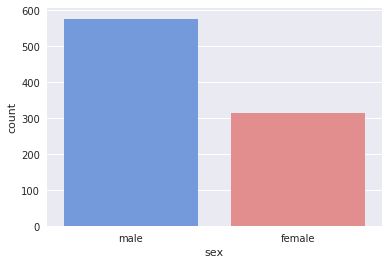

In [9]:
sns.countplot(x="sex", data=titanic, palette=pal);

Посмотрим как распределен пол по классам. Здесь можно воспользоваться сводной таблицей `pd.crosstab()`, а для ее визуализации снова использовать `countplot`.

In [10]:
pd.crosstab(titanic["sex"], titanic["class"])

class,First,Second,Third
sex,,,
female,94,76,144
male,122,108,347


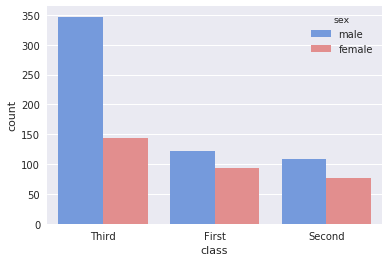

In [11]:
sns.countplot(x="class", data=titanic, hue="sex", palette=pal);

У нас также есть отдельная классификация, которая разделяет детей (это будет актуально из-за правила «сначала женщины и дети», которой следуют во время эвакуации).

In [12]:
titanic["who"].value_counts()

man      537
woman    271
child     83
Name: who, dtype: int64

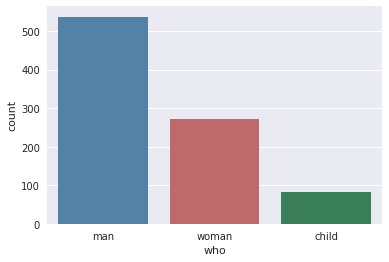

In [13]:
sns.countplot(x="who", data=titanic, palette=pal);

In [14]:
pd.crosstab(titanic["who"], titanic["class"])

class,First,Second,Third
who,,,
child,6,19,58
man,119,99,319
woman,91,66,114


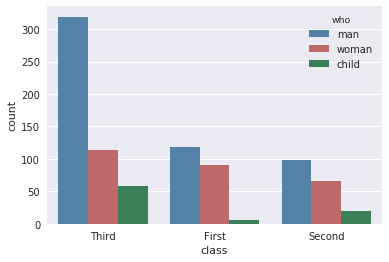

In [15]:
sns.countplot("class", data=titanic, hue="who", palette=pal);

Наконец, мы создали переменную, которая указывает, был ли пассажир взрослым мужчиной.

In [16]:
titanic['adult_male'].value_counts()

True     537
False    354
Name: adult_male, dtype: int64

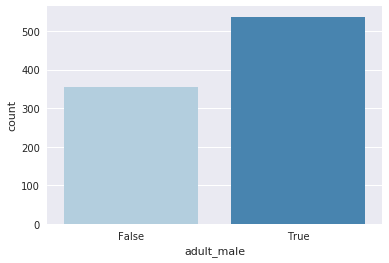

In [17]:
sns.countplot("adult_male", data=titanic, palette="Blues");

In [18]:
pd.crosstab(titanic["adult_male"], titanic["class"])

class,First,Second,Third
adult_male,,,
False,97,85,172
True,119,99,319


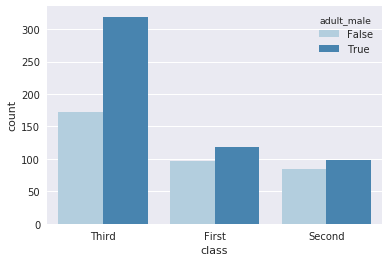

In [19]:
sns.countplot("class", data=titanic, hue="adult_male", palette="Blues");

## Распределение количественного признака

## kdeplot

[kdeplot](https://seaborn.pydata.org/generated/seaborn.kdeplot.html?highlight=kdeplot#seaborn.kdeplot) позволяет строить [сглаженную плотность распределения](https://ru.wikipedia.org/wiki/%D0%AF%D0%B4%D0%B5%D1%80%D0%BD%D0%B0%D1%8F_%D0%BE%D1%86%D0%B5%D0%BD%D0%BA%D0%B0_%D0%BF%D0%BB%D0%BE%D1%82%D0%BD%D0%BE%D1%81%D1%82%D0%B8)

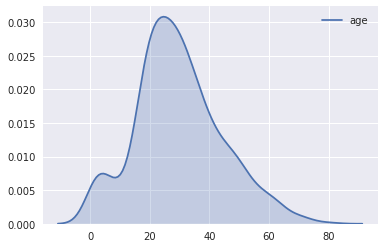

In [20]:
sns.kdeplot(titanic["age"].dropna(), shade=True);

## distplot

[distplot](https://seaborn.pydata.org/generated/seaborn.distplot.html?highlight=distplot#seaborn.distplot) - комбинация гистограммы (hist) и `kdeplot`

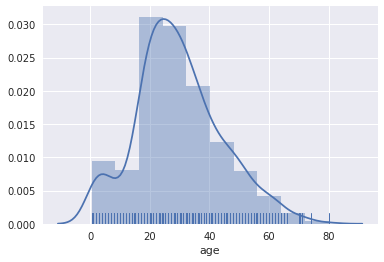

In [21]:
# rug=True отриcовывает засечки соотв. значению величины
sns.distplot(titanic["age"].dropna(), bins=10, rug=True);

## Распределение количественного признака в разрезе качественного

Теперь посмотрим на распределение возраста среди мужчин и женщин.

## FacetGrid

Подробнее об использовании [FacetGrid](https://seaborn.pydata.org/tutorial/axis_grids.html#grid-tutorial)

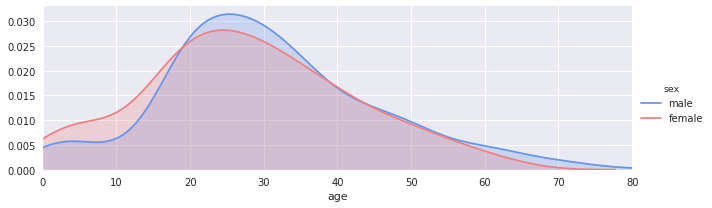

In [22]:
# инициализируем рисунок с помощью FacetGrid
# FacetGrid позволяет отображать разные подмножества с отрисовкой в разные цвет
# нам нужно на одном грфике отобразить два распределения по признаку sex
fg = sns.FacetGrid(titanic, hue="sex", aspect=3, palette=pal, xlim=(0, 80))
# теперь мы ходим построить sns.kdeplot который применим к каждому подмножеству данных
# shape = True закрашивает облать под графиков
fg.map(sns.kdeplot, "age", shade=True).add_legend();

Распределение возраста по категории мужчина, женщина или ребенок

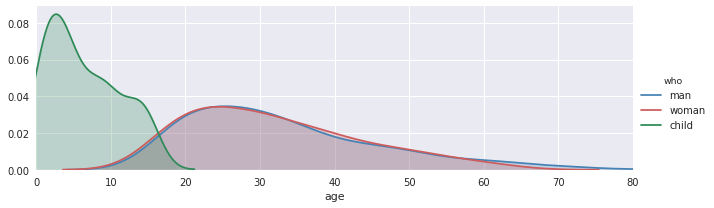

In [23]:
fg = sns.FacetGrid(titanic, hue="who", aspect=3, palette=pal, xlim=(0, 80))
fg.map(sns.kdeplot, "age", shade=True).add_legend();

Распределение возраста по классам

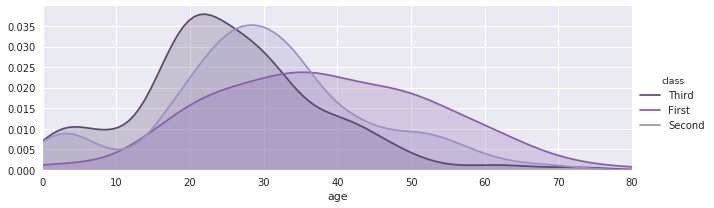

In [24]:
fg = sns.FacetGrid(titanic, hue="class", aspect=3, palette="BuPu_d", xlim=(0, 80))
fg.map(sns.kdeplot, "age", shade=True).add_legend();

Теперь посмотрим на распределение возраста в разресе пол / класс

Посмотрите, теперь нам нужно отрисовать все не на одном графике, поэтому в FacetGrid задаем col="sex", row="class", чтобы колноки соответсвовали разному полу, а строки - классу.

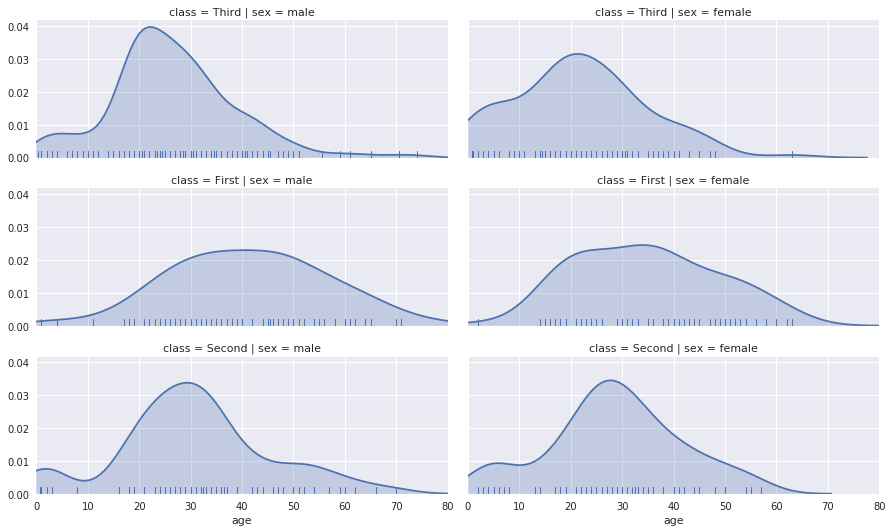

In [25]:
fg = sns.FacetGrid(titanic, col="sex", row="class", size=2.5, aspect=2.5, xlim=(0, 80))
fg.map(sns.kdeplot, "age", shade=True)
# rugplot отрисовывает засечки
fg.map(sns.rugplot, "age");

## violinplot

Поскольку у нас есть данные о тарифах, давайте посмотрим, как они разбиты по классам.

Еще один способ посмтотреть на распределение количественного признака относительно качественного - это использовать `violinplot`

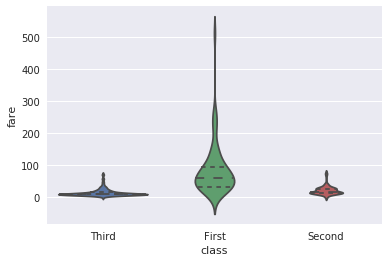

In [26]:
sns.violinplot(x="class", y="fare", data=titanic, scale="count", inner="quartile");

Видно что в данные по первому классу есть значительные выбросы

In [27]:
titanic["fare_winsor"] = titanic.fare.map(lambda f: min(f, 200))

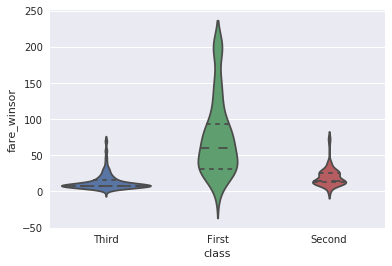

In [28]:
sns.violinplot(x="class", y="fare_winsor", data=titanic, scale="count", inner="quartile");

Еще один популярный способ визуализации это [boxplot](https://seaborn.pydata.org/generated/seaborn.boxplot.html?highlight=boxplot#seaborn.boxplot) или [ящик с усами](https://ru.wikipedia.org/wiki/%D0%AF%D1%89%D0%B8%D0%BA_%D1%81_%D1%83%D1%81%D0%B0%D0%BC%D0%B8)

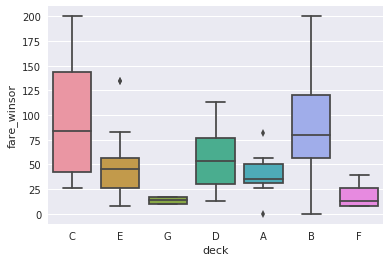

In [29]:
sns.boxplot(x="deck", y="fare_winsor", data=titanic);

Мы также можем посмотреть на регрессию тарифов по возрасту, чтобы увидеть, заплатили ли пассажиры старшего возраста больше. 

## regplot

Документация по [regplot](https://seaborn.pydata.org/generated/seaborn.regplot.html?highlight=regplot#seaborn.regplot)

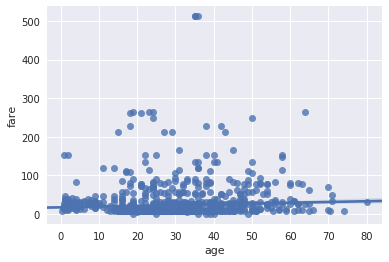

In [30]:
sns.regplot("age", "fare", data=titanic, robust=True);

# <a id="Кто выжил?"><span style="color:green">Кто выжил?</span></a>

<div style="width:100%; text-align:center">
<i>Iceberg, dead ahead!</i><br><br>
<img src=http://upload.wikimedia.org/wikipedia/en/b/bb/Titanic_breaks_in_half.jpg width=500px>
</div>

Перейдем к основному вопросу: кто же выжил?

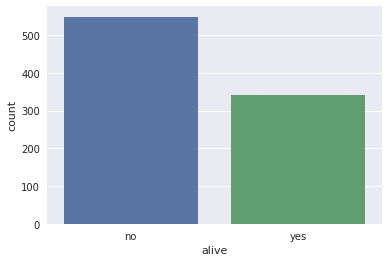

In [31]:
sns.countplot("alive", data=titanic);

### В каких класса путешествовали выжившие?

Существует популярное представление о том, что пассажиры третьего класса жили намного хуже, чем их более состоятельные товарищи по кораблю. Это подтверждается данными?

## pointplot

Домкументация по [pointplot](https://seaborn.pydata.org/generated/seaborn.pointplot.html#seaborn.pointplot)

`pointplot` показывает среднее значение и величину стандратного отклонения (если ci='sd')

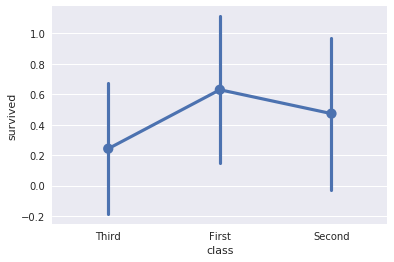

In [32]:
sns.pointplot("class", "survived", data=titanic, ci='sd');

Мы также, конечно, знаем, что женщинам уделяли первостепенное внимание во время эвакуации, и мы видели выше, что третий класс был непропорционально мужским. Может быть из-за этого мы наблюдаем такой эффект на графике выше?

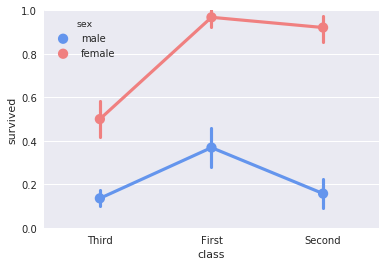

In [33]:
sns.pointplot("class", "survived", data=titanic, hue="sex", palette=pal).set(ylim=(0, 1));

Похоже, что нет

Проверим есть ли влиянения правила "женщины и дети вперед"

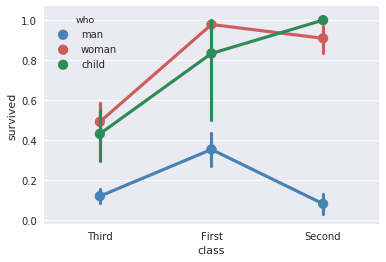

In [34]:
fg = sns.pointplot("class", "survived", data=titanic, hue="who", col="who", palette=pal, aspect=.4);

Мы подозреваем, что лучший способ предсказать выживание - это посмотреть, был ли пассажир взрослым мужчиной и в каком классе он или она был

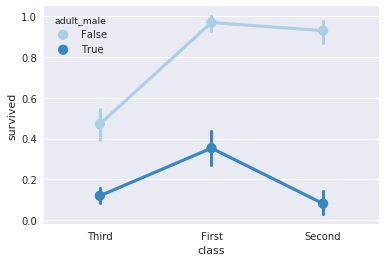

In [35]:
sns.pointplot("class", "survived", data=titanic, hue="adult_male", palette="Blues");

Другой способ построить те же данные подчеркивает различные результаты для мужчин и других пассажиров

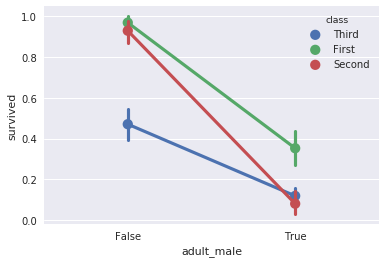

In [36]:
fg = sns.pointplot("adult_male", "survived", data=titanic, col="class", hue="class");

Влияет ли возраст на выживание?

## lmplot

Документация по [lmplot](https://seaborn.pydata.org/generated/seaborn.lmplot.html?highlight=lmplot#seaborn.lmplot)

lmplot рисует график рассеяния двух переменных x и y, а затем подгоняет регрессионную модель y ~ x и строит результирующую линию регрессии и 95% доверительный интервал для этой регрессии.

Пострим логистическую регрессию на данных о возрасте. 

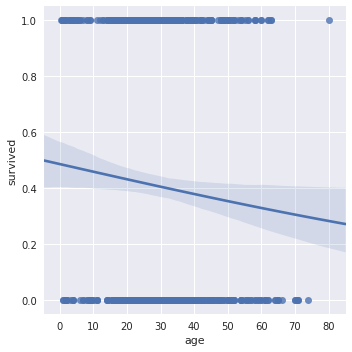

In [37]:
sns.lmplot("age", "survived", titanic, logistic=True);

Мы знаем, что пол пассажира важен, поэтому мы хотим отделить прогнозы для мужчин и женщин.

lmplot позволяет свернуть данные наблюдений в определенной ячейке, чтобы построить оценку центральной тенденции вместе с доверительным интервалом:

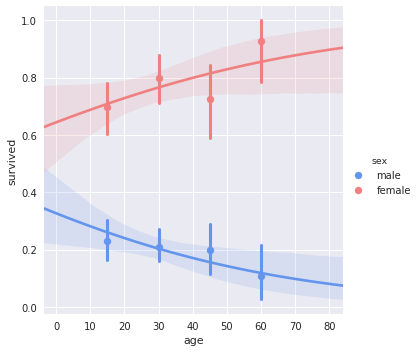

In [38]:
age_bins = [15, 30, 45, 60]
sns.lmplot("age", "survived", titanic, hue="sex", palette=pal, x_bins=age_bins, x_estimator=np.mean, order=1, logistic=True);

Класс также имеет значение:

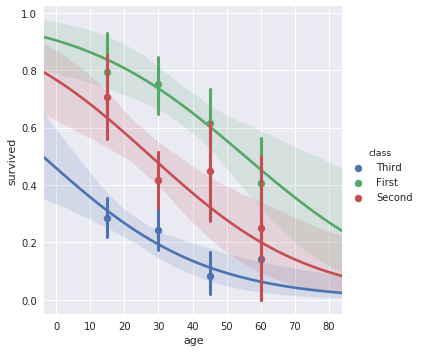

In [39]:
sns.lmplot("age", "survived", titanic, hue="class", x_bins=age_bins, x_estimator=np.mean, logistic=True);

Если вам кажется, что график выше перегружен, можно отрисовать каждый график отдельно:

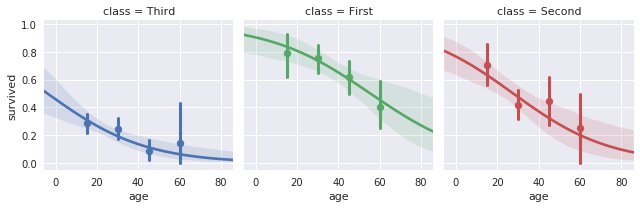

In [40]:
sns.lmplot("age", "survived", titanic, col="class", hue="class", x_bins=age_bins, logistic=True, size=3);